In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# CONSTANTES
BATCH_SIZE = 64
IMG_SIZE = 32
NUM_CLASSES = 10  # nº classes para identificar
NUM_EPOCHS = 30
LEARNING_RATE = 0.001

In [17]:
# Define directories (NESTED!!!)
train_dirs = ['../dataset/train/train1', '../dataset/train/train2', '../dataset/train/train3', '../dataset/train/train5']
validation_dir = '../dataset/validation'
test_dir = '../dataset/test'

In [18]:
# Load VGG16 model
from tensorflow.keras.applications.vgg16 import VGG16
conv_base = VGG16(weights='imagenet', include_top=False)
conv_base.trainable = False


In [19]:
# CRIAR OS GERADORES without augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
# training generators
train_generators = [train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical') for train_dir in train_dirs]

Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [21]:
# Necessário para junstar os trainning generators
def combined_generator(generators):
    while True:
        for generator in generators:
            yield next(generator)

train_generator = combined_generator(train_generators)

In [22]:
# Validation e test generators
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [23]:
# Compute the output of the feature extraction section for each of the datasets
def get_features_and_labels(generator, steps):
    all_features = []
    all_labels = []
    for i in range(steps):
        images, labels = next(generator)
        preprocessed_images = tf.keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [24]:
steps_per_epoch = sum([gen.samples // BATCH_SIZE for gen in train_generators])
train_features, train_labels = get_features_and_labels(train_generator, steps_per_epoch)

validation_steps = validation_generator.samples // BATCH_SIZE
val_features, val_labels = get_features_and_labels(validation_generator, validation_steps)

test_steps = test_generator.samples // BATCH_SIZE
test_features, test_labels = get_features_and_labels(test_generator, test_steps)

2/2 [==============================] - 0s 8ms/step


In [25]:
# Define the new model
model = Sequential([
    Flatten(input_shape=train_features.shape[1:]),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

In [26]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                      

In [27]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
csv_logger = CSVLogger(f'feature_extraction_aug_notpretrained_batch_size_{BATCH_SIZE}_image_size_{IMG_SIZE}.csv', append=True)

# Train the model
history = model.fit(
    train_features, train_labels,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_features, val_labels),
    callbacks=[checkpoint, early_stopping, csv_logger]
)

Epoch 1/30
606/624 [============================>.] - ETA: 0s - loss: 2.2620 - accuracy: 0.2009
Epoch 1: val_accuracy improved from -inf to 0.14884, saving model to best_model.keras
624/624 [==============================] - 2s 3ms/step - loss: 2.2580 - accuracy: 0.2019 - val_loss: 4.5830 - val_accuracy: 0.1488
Epoch 2/30
609/624 [============================>.] - ETA: 0s - loss: 2.0862 - accuracy: 0.2357
Epoch 2: val_accuracy did not improve from 0.14884
624/624 [==============================] - 2s 3ms/step - loss: 2.0853 - accuracy: 0.2361 - val_loss: 15.4451 - val_accuracy: 0.1026
Epoch 3/30
606/624 [============================>.] - ETA: 0s - loss: 2.0490 - accuracy: 0.2477
Epoch 3: val_accuracy did not improve from 0.14884
624/624 [==============================] - 2s 3ms/step - loss: 2.0489 - accuracy: 0.2478 - val_loss: 7.4430 - val_accuracy: 0.1104
Epoch 4/30
617/624 [============================>.] - ETA: 0s - loss: 2.0299 - accuracy: 0.2566
Epoch 4: val_accuracy did not impr

312/312 [==============================] - 1s 3ms/step - loss: 4.5738 - accuracy: 0.1466
Test Accuracy: 0.14663460850715637


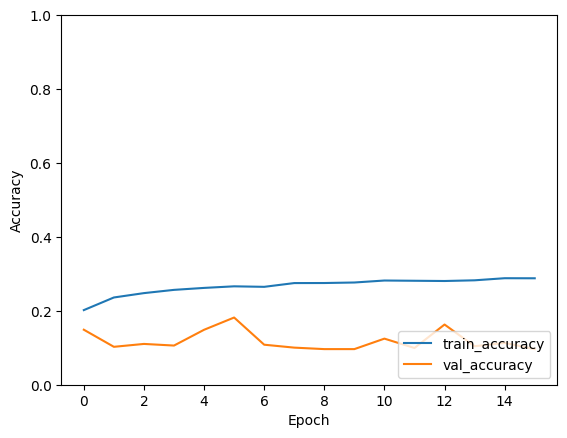

In [28]:
# Evaluate the model
loss, accuracy = model.evaluate(test_features, test_labels)
print("Test Accuracy:", accuracy)

# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()